## <div class="alert alert-info"><h1>Imports</h1></div>

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
import joblib
import sklearn
import itertools
from sklearn import __version__ as sklearn_version
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, RandomizedSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from joblib import Parallel, parallel_backend
from collections import Counter

#Start a timer to check the execution time of the notebook.
start_time = time.time()

## <div class="alert alert-info"><h1>Function Definitions</h1></div>

In [2]:
def simulate_feature_change(feature_name, delta, X_data, model):
    """
    Simulates how changing a specific feature affects predicted access probability.

    Arguments:
    - feature_name (str): The feature to modify.
    - delta (float): The percentage or absolute change to apply.
    - X_data (DataFrame): The input dataset (feature matrix).
    - model: The trained machine learning model.

    Returns:
    - A dictionary with probability-based access changes and insights.
    """

    # Create a modified copy of the dataset
    X_modified = X_data.copy()

    # Apply the percentage increase/decrease
    if X_modified[feature_name].dtype in [np.float64, np.int64]:  # Only modify numerical features
        X_modified[feature_name] *= (1 + delta)  # Example: Increase by 10% if delta = 0.1

    # Predict probabilities instead of discrete labels
    original_probs = model.predict_proba(X_data)[:, 1]  # Probability of "access"
    modified_probs = model.predict_proba(X_modified)[:, 1]

    # Compute probability differences
    prob_diffs = modified_probs - original_probs
    relative_change = prob_diffs / (original_probs + 1e-6)  # Avoid division by zero

    # Compute statistics
    num_nonzero = np.count_nonzero(prob_diffs)  # How many samples saw a probability change?
    mean_abs_change = np.mean(np.abs(prob_diffs))  # Average absolute probability shift
    mean_relative_change = np.mean(relative_change)  # Average relative probability shift

    return {
        "feature": feature_name,
        "original_mean_access": round(np.mean(original_probs), 4),
        "modified_mean_access": round(np.mean(modified_probs), 4),
        "change_in_access": round(np.mean(prob_diffs), 4),  # Now based on probability shift
        "num_samples_affected": num_nonzero,
        "mean_abs_prob_change": round(mean_abs_change, 4),
        "mean_relative_prob_change": round(mean_relative_change, 4)
    }


In [3]:
def plot_simulation_results(results_df, feature_name):
    """
    Plots the simulation results for a given feature.

    Args:
        results_df (pd.DataFrame): DataFrame with 'delta' and 'result' columns.
        feature_name (str): The name of the feature to plot.
    """

    feature_data = results_df[results_df['feature'] == feature_name]
    
    # Cosmetic changes to feature_name for plot labels
    #formatted_feature_name = feature_name.replace("_", " ").title()

    # Use descriptive feature name from the dictionary
    formatted_feature_name = feature_descriptions.get(feature_name, feature_name)  # Use original if not found

    plt.plot(feature_data['delta'], feature_data['result'], marker='o')
    plt.title(f"Simulation Results for {formatted_feature_name}")
    plt.xlabel(f"{formatted_feature_name} Improvement")
    plt.ylabel("Change in Access")
    plt.grid(True)
    plt.show()

In [4]:
def simulate_two_feature_change(feature1, feature2, delta, X_data, model):
    """
    Simulates how changing TWO features at the same time affects predicted access probability.

    Arguments:
    - feature1 (str): First feature to modify.
    - feature2 (str): Second feature to modify.
    - delta (float): The percentage or absolute change to apply.
    - X_data (DataFrame): The input dataset (feature matrix).
    - model: The trained machine learning model.

    Returns:
    - A dictionary with probability-based access changes.
    """

    X_modified = X_data.copy()

    # Apply the percentage increase/decrease to BOTH features
    for feature in [feature1, feature2]:
        if X_modified[feature].dtype in [np.float64, np.int64]:  
            X_modified[feature] *= (1 + delta)  

    # Predict probabilities
    original_probs = model.predict_proba(X_data)[:, 1]  # Probability of "access"
    modified_probs = model.predict_proba(X_modified)[:, 1]

    # Compute probability differences
    prob_diffs = modified_probs - original_probs
    relative_change = prob_diffs / (original_probs + 1e-6)  

    return {
        "feature1": feature1,
        "feature2": feature2,
        "delta": delta,
        "original_mean_access": round(np.mean(original_probs), 4),
        "modified_mean_access": round(np.mean(modified_probs), 4),
        "change_in_access": round(np.mean(prob_diffs), 4),  # Probability shift
        "num_samples_affected": np.count_nonzero(prob_diffs),
        "mean_abs_prob_change": round(np.mean(np.abs(prob_diffs)), 4),
        "mean_relative_prob_change": round(np.mean(relative_change), 4)
    }


In [5]:
def plot_compare(feat_name, description, figsize=(12, 6)):
    """
    Graphically compare distributions of features.
    
    Plots a histogram of values for all states and adds a vertical red dashed
    line to indicate the position of race==2.

    Arguments:
    - feat_name (str): The feature column name in the data.
    - description (str): Text description of the feature.
    - figsize (tuple): Optional figure size (default is (12,6)).
    """
    fig, ax = plt.subplots(figsize=figsize)

    # Plot histogram of the feature for all data (No KDE)
    hist = sns.histplot(full_data[feat_name], bins=30, kde=False, alpha=0.6, ax=ax)

    # Adjust text placement based on bar height
    y_max = ax.get_ylim()[1]  # Get the max y-axis limit

    # Annotate bars with counts
    for patch in hist.patches:
        height = patch.get_height()
        if height > 0:  # Only label non-zero bars
            label_y = min(height, y_max * 0.9)  # Keeps label inside the chart
            ax.text(patch.get_x() + patch.get_width()/2, label_y, f'{int(height)}', 
                    ha='center', va='bottom', fontsize=10, color='black', rotation=90)

    # Ensure we use the cleaned predictions for race==2
    race2_values = pd.Series(bm_pred_mapped)  # Use mapped predictions

    # Use the mode (most frequent access category) instead of the mean
    race2_mode = race2_values.mode()[0]

    # Plot a vertical red dashed line for race==2 using the mode
    ax.axvline(x=race2_mode, c='r', ls='--', alpha=0.8, label="Race = Black")

    # Titles and labels
    ax.set_title(f'Distribution of {description}')
    ax.set_xlabel(description)
    ax.set_ylabel('Count')
    ax.legend()

    plt.show()

## <div class="alert alert-info"><h1>Load the Model</h1></div>

In [6]:
# Define model path
modelpath = '../models'

# Define filename
model_filename = os.path.join(modelpath, "health_care_access_model.pkl")

expected_model_version = '1.0'

# Check if file exists and load
if os.path.exists(model_filename):
    model = joblib.load(model_filename)  # No need for 'with open()'
    print(f"✅ Model loaded successfully: {type(model)}")

    # Verify it's a pipeline and print its steps
    if isinstance(model, Pipeline):
        print("Pipeline Steps:", model.named_steps)
    else:
        print("Warning: Model is not a Pipeline")
else:
    print("❌ Model file not found")

✅ Model loaded successfully: <class 'sklearn.pipeline.Pipeline'>
Pipeline Steps: {'simpleimputer': SimpleImputer(), 'standardscaler': None, 'randomforestregressor': RandomForestRegressor(n_estimators=500, random_state=47)}


## <div class="alert alert-info"><h2>Load the Data</h2></div>

In [7]:
datapath = '../data'
# Specify the file path
file_path = f'{datapath}/health_cdc_data_EDA_features.csv'

# Data without black race
health_access_data = pd.read_csv(file_path)

# Specify the file path for black race data
file_path = f'{datapath}/black_race_data.csv'

# Data of just black race
blk_data = pd.read_csv(file_path)

In [8]:
health_access_data.head()

,region,state,city,total_days_of_care,total_charges,total_cases,min_copay_for_new_patient,max_copay_for_new_patient,mode_copay_for_new_patient,min_copay_for_established_patient,...,hearingdf,state_total_hispallp,occupation_per_100kcapita,occupation_per_100ksq_mile,race_ratio,access_ratio,discrimination_ratio,vigilance_ratio,sex_ratio,hispanic_ratio
0,south,south carolina,Sumter,16460.0,131894850.0,3156.0,120.562500,368.75000,187.125000,38.187500,...,1.0,31606,0.718626,115.552780,0.000041,0.000057,0.000083,0.000075,0.000091,0.000063
1,south,texas,Huffman,527.0,7650966.0,72.0,43.687500,132.75000,67.812500,13.953125,...,1.0,106227,0.127604,13.775335,0.000025,0.000017,0.000025,0.000022,0.000027,0.000028
2,south,oklahoma,Oktaha,220.0,2020002.0,58.0,13.250000,40.65625,20.609375,4.171875,...,1.0,34405,0.909787,51.502883,0.000038,0.000052,0.000076,0.000069,0.000041,0.000058
3,midwest,minnesota,Zumbrota,49.0,321551.0,13.0,14.000000,42.06250,21.453125,4.578125,...,1.0,27092,0.656071,42.560044,0.000060,0.000067,0.000098,0.000085,0.000051,0.000074
4,south,texas,Hubbard,242.0,2751082.0,50.0,13.710938,41.71875,21.234375,4.382812,...,1.0,106227,0.127604,13.775335,0.000012,0.000017,0.000025,0.000022,0.000027,0.000019


In [9]:
blk_data.head()

,region,state,city,total_days_of_care,total_charges,total_cases,mode_copay_for_new_patient,mode_copay_for_established_patient,total_agi,race,...,depev,hearingdf,occupation_per_100kcapita,occupation_per_100ksq_mile,race_ratio,access_ratio,discrimination_ratio,vigilance_ratio,sex_ratio,hispanic_ratio
0,south,texas,Huffman,527.0,7650966.0,72.0,67.8125,77.062500,1939422.0,2.0,...,1.0,1.0,0.127604,13.775335,0.000025,0.000017,0.000025,0.000022,0.000027,0.000028
1,south,west virginia,Harrisville,180.0,2777041.0,28.0,20.8750,23.703125,78047.0,2.0,...,2.0,1.0,1.952965,144.449030,0.000072,0.000050,0.000059,0.000066,0.000040,0.000084
2,south,alabama,Moulton,692.0,12128407.0,141.0,40.9375,46.875000,710862.0,2.0,...,2.0,1.0,0.734217,68.676078,0.000059,0.000041,0.000024,0.000054,0.000065,0.000068
3,south,louisiana,Monroe,7701.0,76742790.0,979.0,209.0000,237.750000,6942040.0,2.0,...,2.0,1.0,0.774394,68.731147,0.000078,0.000054,0.000079,0.000071,0.000043,0.000090
4,south,maryland,Dunkirk,112.0,544773.0,11.0,22.4375,25.531250,468760.0,2.0,...,2.0,1.0,0.612007,298.242786,0.000092,0.000063,0.000074,0.000017,0.000050,0.000104


In [10]:
# Use blk_data as the reference for feature selection
feature_cols = list(blk_data.columns)  # Get the correct columns

# Keep only matching columns in health_access_data
health_access_data = health_access_data[feature_cols]  # Drop the 6 extra columns

<div class="alert alert-info"><strong>Extracting Black race from the rest of the data</strong></div>

<div style="background-color: rgba(128, 0, 128, 0.7); padding: 10px; color: white;"> Race definition:<br>
1 White<br> 
2 Black/African American <br>
3 Asian <br>
4 AIAN <br>
5 AIAN and any other group <br>
6 Other single and multiple races <br>
7 Refused <br>
8 Not Ascertained<br>
9 Don't know

<div style="background-color: rgba(128, 0, 128, 0.7); padding: 10px; color: white;"> Hispanic definition:<br>
1 Hispanic <br>
2 Non-Hispanic White only <br>
3 Non-Hispanic Black/African American only <br>
4 Non-Hispanic Asian only <br>
5 Non-Hispanic AIAN only <br>
6 Non-Hispanic AIAN and any other group <br>
7 Other single and multiple races <br>

In [11]:
health_access_data.shape

(621951, 37)

In [12]:
health_access_data = health_access_data[health_access_data.race !=2]

In [13]:
health_access_data.shape

(540150, 37)

In [14]:
blk_data.shape

(81801, 37)

In [15]:
# Combine both datasets before setting X, y
full_data = pd.concat([health_access_data, blk_data], axis=0).reset_index(drop=True)

In [16]:
full_data = full_data.drop(
    columns=['region', 'state', 'city', 'aggregation_level', 
             'race_ratio', 'hispanic_ratio', 'hispanic', 'state_total_hispallp', 'hisdetp'], 
    errors='ignore'
)

In [17]:
full_data.shape

(621951, 30)

<div class="alert alert-info">Refit Model On All Available Data</div>

In [18]:
# Define mapping
access_mapping = {
    1: 1,  # "Yes" → Has Access
    2: 0,  # "There is NO place" → No Access
    3: 1,  # "More than one place" → Has Access
    7: None,  # Exclude
    8: None,  # Exclude
    9: None   # Exclude
}

# Apply mapping
y = full_data["access"].map(access_mapping)

# Drop NaN values (refused/not ascertained/don't know)
y = y.dropna().astype(int)

X = full_data.drop(columns=['access'], errors='ignore')

# Keep only rows where 'access' exists
X = X.loc[y.index]  # Ensure X matches y




In [19]:
print(y.unique())  # Should only show [0, 1]

[1 0]


In [20]:
len(y), len(X)

(615479, 615479)

In [21]:
print(full_data["access"].unique())  # Check unique values in the access column



[1. 2. 8. 3. 9. 7.]


In [22]:
# Parallelizing tree construction
with parallel_backend('threading', n_jobs=-1):  # Use all CPU cores
    model.fit(X, y)

In [23]:
print("Feature Importances:", model.named_steps['randomforestregressor'].feature_importances_)
print("Training Score:", model.score(X, y))


Feature Importances: [3.48258191e-06 3.17551700e-06 2.22230605e-06 4.59227469e-04
 1.40550207e-03 1.22130367e-05 1.59239514e-04 9.77342926e-04
 3.20025423e-03 1.68139619e-02 1.15301354e-05 2.78854360e-04
 0.00000000e+00 4.50133217e-04 3.09941218e-05 1.17323393e-05
 2.28962882e-04 3.41485366e-04 1.13828323e-05 8.34779651e-05
 5.10447234e-05 1.38350085e-04 1.49486558e-04 8.14217659e-02
 5.58742145e-02 4.00336907e-01 3.32432464e-03 3.66424341e-01
 6.77943910e-02]
Training Score: 0.9999875091169925


<div class="alert alert-info">The original model was built on a 50/50 train/test split.<br>
    The trraining score of 0.9999 suggests overfitting trap. <br>
    We will use 80/20 split as this is the norm. <br>
    We will use the same hyperparameters to compare performance.<br>
    For the purpose of this exercise, we will assume Random Forest Model is still the best model.<br><br>
    Hyperparameters will be optimized at a later stage down below. 
    </div>

In [24]:
# 80/20 split for better generalization
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

In [25]:
#Define a pipeline comprising the steps:
#SimpleImputer() with a strategy of 'median'
#StandardScaler(),
#and then RandomForestRegressor() with a random state of 47
RF_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),RandomForestRegressor
    (random_state=47)
)

In [26]:
cv=3
n_est = [50,100, 500]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [None], # Skip scaling since RF handles unscaled data well
        'simpleimputer__strategy': ['mean', 'median']
}

grid_params

{'randomforestregressor__n_estimators': [50, 100, 500],
 'standardscaler': [None],
 'simpleimputer__strategy': ['mean', 'median']}

In [27]:
#Call `GridSearchCV` with the random forest pipeline, passing in the above `grid_params`
#dict for parameters to evaluate, 3-fold cross-validation, and all available CPU cores (if desired)
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=cv, n_jobs=-1)

In [28]:
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [50, 100, 500],
                         'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler': [None]})

In [29]:
# Evaluate performance
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")

Train Score: 0.9999884715750821
Test Score: 0.9999836039441001


<div class="alert alert-info">Overfitting is possible - Model generalizes well but needs to be watched carefully.<br>
No Underfitting – High accuracy, so it's capturing patterns well.<br>
Hyperparameters are solid. We will tweak later, but this is already really strong performance!
    </div>

In [30]:
best_model = rf_grid_cv.best_estimator_

print(best_model.named_steps['randomforestregressor'].feature_importances_)


[6.21614205e-06 9.64528157e-06 6.03289230e-06 5.44010092e-04
 1.37512839e-03 1.83274967e-05 8.99354637e-05 1.05445570e-03
 2.05058429e-03 1.70109509e-02 1.63431835e-05 2.55913482e-04
 0.00000000e+00 4.36076837e-04 2.96816041e-05 1.31946985e-05
 2.23021561e-04 3.48143089e-04 7.25379350e-06 3.92728094e-05
 3.74744488e-05 8.04133756e-05 1.16752384e-04 8.31379662e-02
 5.51465474e-02 3.99664428e-01 3.06669036e-03 3.68333772e-01
 6.68817682e-02]


<div class="alert alert-info">Feature importance values are well distributed<br>
    </div>

In [31]:
feature_names = X.columns
important_features = sorted(zip(feature_names, best_model.named_steps['randomforestregressor'].feature_importances_), key=lambda x: x[1], reverse=True)
print(important_features[:5])  # Show top 5 most important features

[('access_ratio', np.float64(0.39966442751385983)), ('vigilance_ratio', np.float64(0.3683337723607856)), ('occupation_per_100kcapita', np.float64(0.08313796617704637)), ('sex_ratio', np.float64(0.06688176822459772)), ('occupation_per_100ksq_mile', np.float64(0.055146547417558214))]


<div class="alert alert-info">We had a stong data leakage.<br>
The top features were all related to race in some way. <br>

From the above validation, this is the original list. [('race_ratio', np.float64(0.5954412600092439)), ('hispanic_ratio', np.float64(0.22057270048133962)), ('hispanic', np.float64(0.17521422887263005)), ('state_total_hispallp', np.float64(0.005436467136265639)), ('hisdetp', np.float64(0.0013955647039849623))] <br>
We droped these features up top and redid the exersice. <br>
This note will not make sense after the redo.<br>
However, we will keep it as reference.
We now have what we need to preoceed
    </div>

In [32]:
#We will save the new model. 
best_model.metadata = {
    "version": "1.0",
    "pandas_version": pd.__version__,
    "numpy_version": np.__version__,
    "sklearn_version": sklearn.__version__,
    "X_columns": list(X_train.columns),
    "build_datetime": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
}

In [33]:
model = best_model

<div class="alert alert-info">Fit the model with 100% of the data.

In [34]:
model.fit(X,y)

Pipeline(steps=[('simpleimputer', SimpleImputer()), ('standardscaler', None),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=500, random_state=47))])

In [35]:
cv_results = cross_validate(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

In [36]:
cv_results['test_score']

array([-7.32891402e-05, -8.35250536e-05, -1.13428122e-03])

In [37]:
mae_mean, mae_std = np.mean(-1 * cv_results['test_score']), np.std(-1 * cv_results['test_score'])
mae_mean, mae_std

(np.float64(0.0004303651366108013), np.float64(0.0004977613743098227))

<div class="alert alert-info">Calculate Black Healthcare Access From The Model</div>

In [38]:
# Ensure feature names are correctly extracted
feature_cols = list(X.columns)  # Extract only the features used in training

# Filter for race==2 first, THEN select feature columns
X_bm = X.loc[full_data['race'] == 2, feature_cols]

# Get the corresponding target variable for race==2
y_bm = y.loc[full_data['race'] == 2]

# Check if X_bm is empty before predicting
if X_bm.shape[0] == 0:
    print("No samples found for race==2! Check your dataset.")
else:
    bm_pred = model.predict(X_bm)  # Predict for all race==2 rows
    print(f"Predictions for race==2 (Black): {bm_pred}")

Predictions for race==2 (Black): [1. 1. 1. ... 1. 0. 0.]


In [39]:
bm_pred.shape

(79556,)

In [40]:
X_bm.shape

(79556, 29)

In [41]:
bm_preds = model.predict(X_bm)  # Get all predictions

if bm_preds.shape[0] == 1:
    bm_pred = bm_preds.item()  # Extract scalar if only one prediction
    print(f"Single prediction for race==2: {bm_pred}")
else:
    bm_pred_mean = bm_preds.mean()  # Aggregate multiple predictions
    print(f"Mean predicted access for race==2: {bm_pred_mean}")

Mean predicted access for race==2: 0.8935965609130675


In [42]:
# Round to the nearest valid category
bm_pred_rounded = [round(val) for val in bm_preds]  

print(f"Rounded Predictions: {bm_pred_rounded[:10]}")  # Show first 10 predictions

# Count the frequency of each predicted category
pred_counts = Counter(bm_pred_rounded)


Rounded Predictions: [1, 1, 1, 1, 1, 1, 1, 1, 1, 0]


In [43]:
# Define valid access categories from the dataset
valid_access_categories = [0,1]

# Map each prediction to the closest valid category
bm_pred_mapped = [min(valid_access_categories, key=lambda x: abs(x - pred)) for pred in bm_pred_rounded]

# Count new mapped predictions
from collections import Counter
mapped_counts = Counter(bm_pred_mapped)

print("\nMapped Prediction Counts:")
for category, count in sorted(mapped_counts.items()):
    print(f"Access {category}: {count} occurrences")



Mapped Prediction Counts:
Access 0: 8465 occurrences
Access 1: 71091 occurrences


<div style="background-color: rgba(128, 0, 128, 0.7); padding: 10px; color: white;"> Access definition:<br>
1 Access to Healthcare = Yes - set to 1<br> 
2 Access to Healthcare = No - set to 0<br>
3 There is MORE THAN ONE place - set to 1<br>
7 Refused - set to 0 <br>
8 Not Ascertained - set to 0<br>
9 Don't know - set to 0

In [44]:
y_bm_mean = y_bm.mean()
print(f"Mean of y_bm: {y_bm_mean}")

Mean of y_bm: 0.8935969631454573


<div class="alert alert-info">The predicted mean is 1.85. <br>

</div>

In [45]:
print(f'Black modelled healthcare access is {bm_pred_mean:.2f}, actual access is {y_bm_mean:.2f}.')
print(f'Even with the expected mean absolute error of {mae_mean:.2f}, this suggests there is more work needed to validate the model.')

Black modelled healthcare access is 0.89, actual access is 0.89.
Even with the expected mean absolute error of 0.00, this suggests there is more work needed to validate the model.


<div class="alert alert-info">Let's check which features are causing this imbalance.
</div>

In [46]:
importances = model.named_steps['randomforestregressor'].feature_importances_
feature_importance = sorted(zip(X.columns, importances), key=lambda x: x[1], reverse=True)

print("\nTop 10 Most Important Features:")
for feature, importance in feature_importance[:10]:
    print(f"{feature}: {importance:.4f}")


Top 10 Most Important Features:
access_ratio: 0.4003
vigilance_ratio: 0.3664
occupation_per_100kcapita: 0.0814
sex_ratio: 0.0678
occupation_per_100ksq_mile: 0.0559
vigilance: 0.0168
discrimination_ratio: 0.0033
discrimination: 0.0032
mode_copay_for_established_patient: 0.0014
sex: 0.0010


<div class="alert alert-info">Let's check which features correlations to access
</div>

In [47]:
print(full_data.corr()['access'].sort_values(ascending=False))


access                                1.000000
gtgrisk                               0.570745
mhthrpy                               0.479777
ecigev                                0.415930
citznstp                              0.399160
marital                               0.325105
ahearst1                              0.307366
access_ratio                          0.269799
discrim3                              0.229377
vigilance                             0.221011
discrimination                        0.218151
medicare                              0.106253
demenev                               0.098383
depev                                 0.040289
race                                  0.032049
discrimination_ratio                  0.026064
hearingdf                             0.023878
vigilance_ratio                       0.019855
total_days_of_care                    0.000605
total_cases                           0.000557
total_charges                         0.000144
occupation_pe

<div class="alert alert-info">Dropping overweight features and refitting the model.
</div>

In [48]:
drop_features = ['gtgrisk', 'mhthrpy', 'ecigev', 'citznstp']  # High correlation features

X_filtered = X.drop(columns=drop_features, errors='ignore')  # Drop them from features
X_train_filtered, X_test_filtered, y_train, y_test = train_test_split(
    X_filtered, y, test_size=0.2, random_state=42, shuffle=True
)

# Fit the model again with filtered features
#model.fit(X_train_filtered, y_train)

In [49]:
# Compute class weights
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

# Modify pipeline to use classifier instead of regressor
model = Pipeline(steps=[
    ('simpleimputer', SimpleImputer(strategy='median')),
    ('standardscaler', None),  # Optional, RF doesn't need scaling
    ('randomforestclassifier', RandomForestClassifier(n_estimators=100, random_state=47, class_weight="balanced"))
])

# Fit the model with class weighting passed to RandomForestClassifier
model.fit(X_train_filtered, y_train, randomforestclassifier__sample_weight=sample_weights)


print("Model trained with feature selection & class weights in one step.")

Model trained with feature selection & class weights in one step.


In [50]:
# Ensure we use the same filtered feature set
X_bm = X.loc[X['race'] == 2, X_filtered.columns]

# Get the corresponding target variable for race==2
y_bm = y.loc[full_data['race'] == 2]

In [51]:
# Define valid access categories
valid_access_categories = [1, 2, 3, 7, 8]

bm_pred = model.predict(X_bm)
# Predict values
bm_pred = model.predict(X_bm)

# Map each prediction to the closest valid category
bm_pred_mapped = [min(valid_access_categories, key=lambda x: abs(x - pred)) for pred in bm_pred]

# Compute mean
bm_pred_mean = np.mean(bm_pred_mapped)

print(f"New Mean Predicted Access for race==2: {bm_pred_mean:.2f}")

# Count new mapped predictions
from collections import Counter
pred_counts = Counter(bm_pred_mapped)

print("\nNew Predicted Access Counts for race==2:")
for category, count in sorted(pred_counts.items()):
    print(f"Access {category}: {count} occurrences")

New Mean Predicted Access for race==2: 1.00

New Predicted Access Counts for race==2:
Access 1: 79556 occurrences


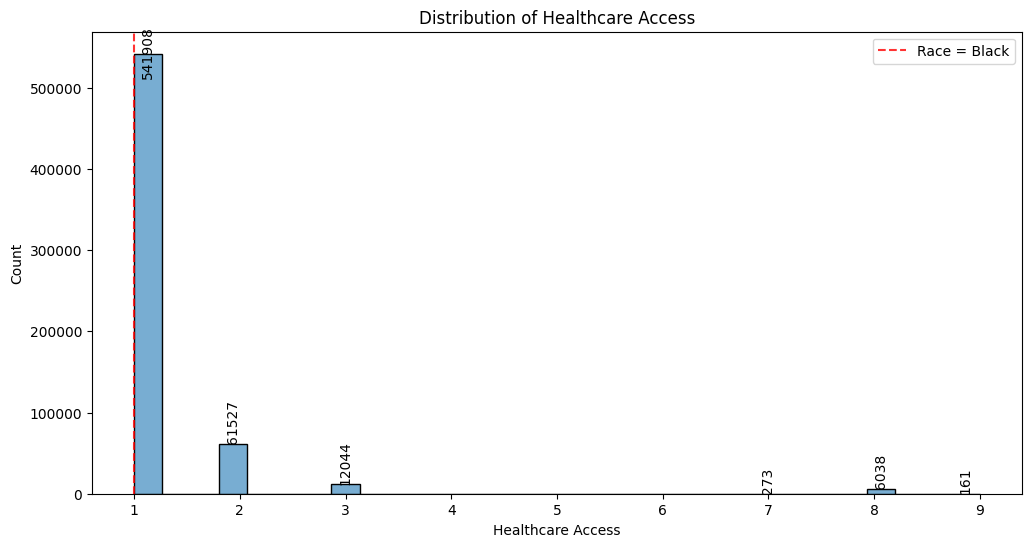

In [52]:
plot_compare('access','Healthcare Access')

In [53]:
feature_importance = model.named_steps['randomforestclassifier'].feature_importances_

feature_names = X_bm.columns
sorted_features = sorted(zip(feature_names, feature_importance), key=lambda x: x[1], reverse=True)
print(sorted_features[:10])  # Show top 10 important features


[('access_ratio', np.float64(0.4941605148513012)), ('occupation_per_100ksq_mile', np.float64(0.08663903425190352)), ('occupation_per_100kcapita', np.float64(0.06515915851723013)), ('sex_ratio', np.float64(0.057402217763894106)), ('vigilance_ratio', np.float64(0.05663755344510301)), ('discrimination_ratio', np.float64(0.03939092825014312)), ('medicare', np.float64(0.03466841791912114)), ('paillmb3m', np.float64(0.02643993011885603)), ('discrimination', np.float64(0.01734882768116422)), ('ahearst1', np.float64(0.016764733763189883))]


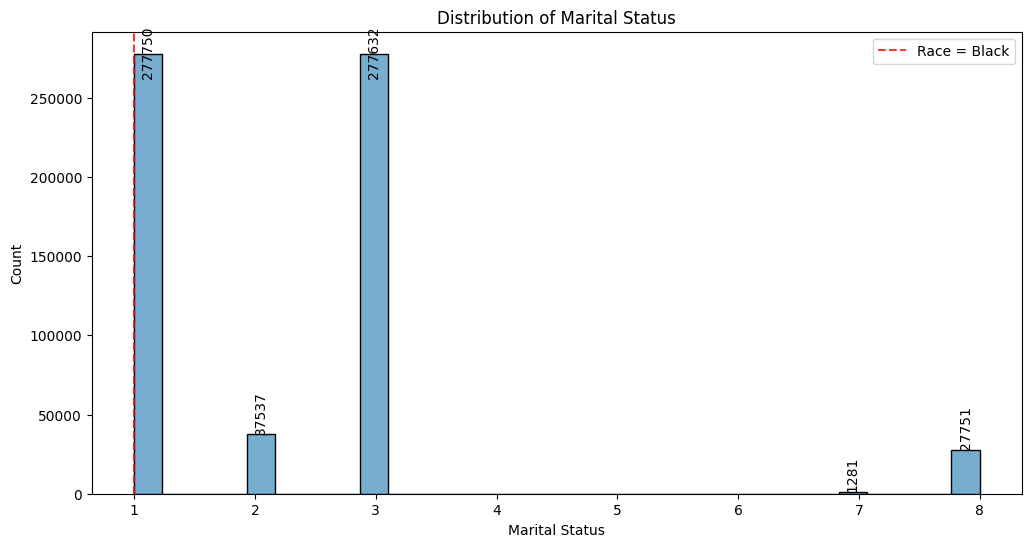

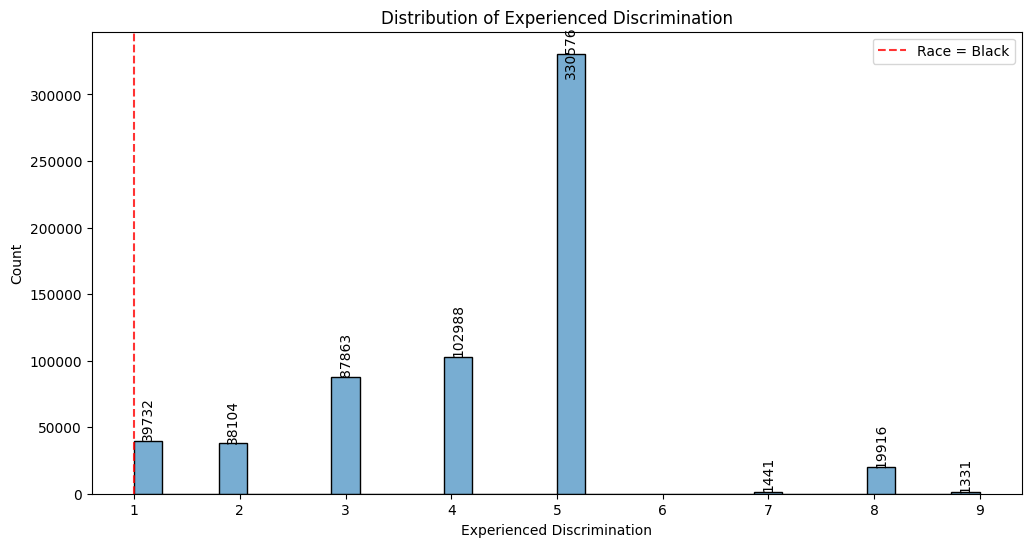

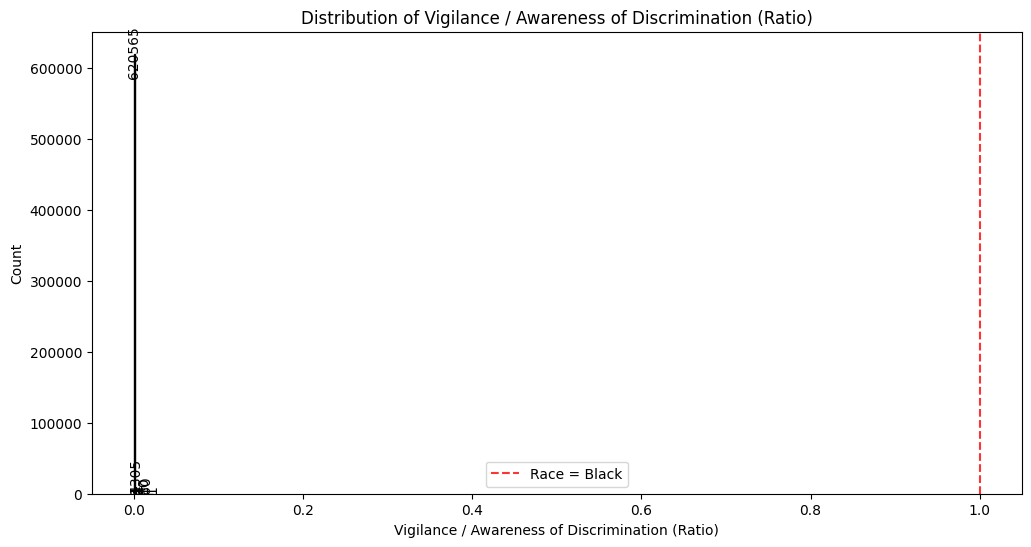

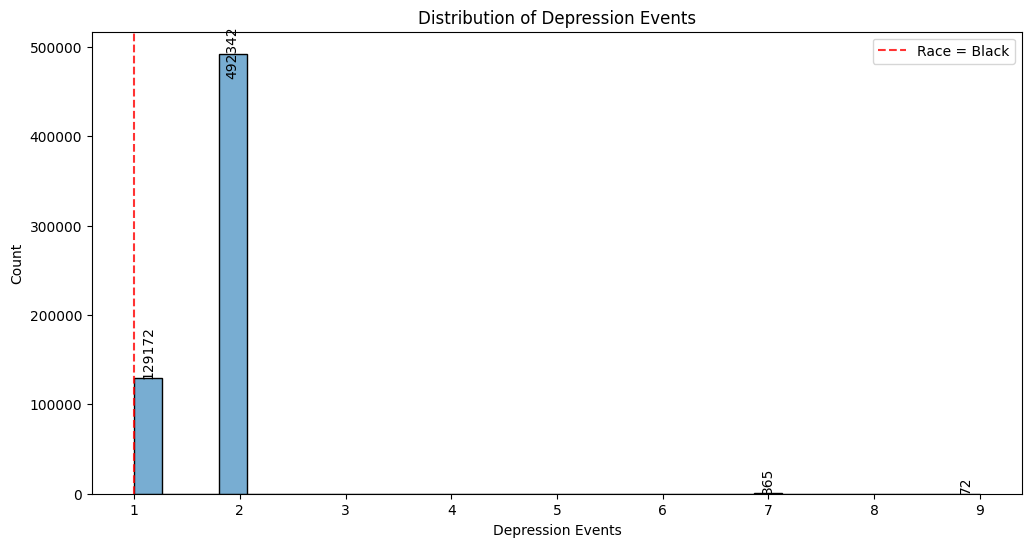

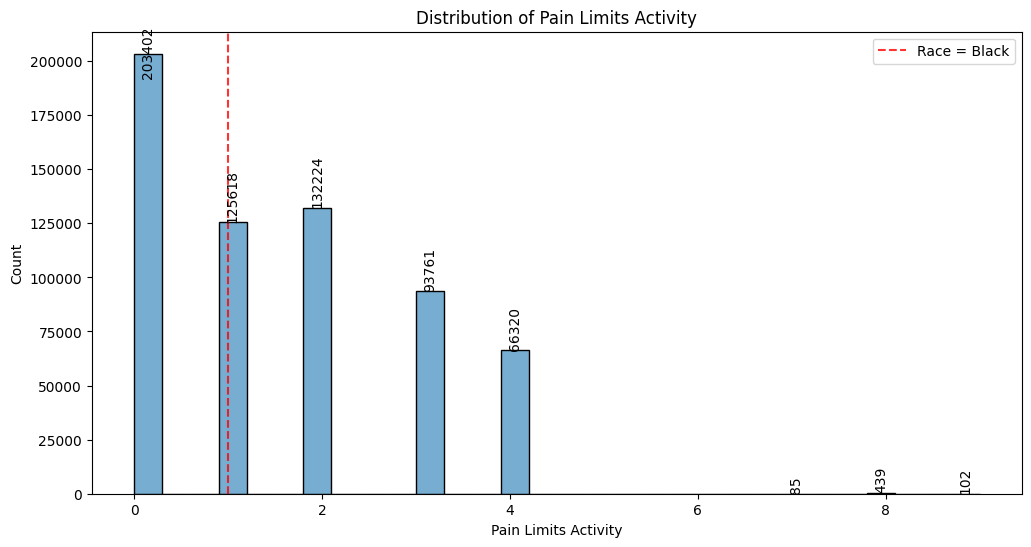

In [54]:
# Mapping of feature names to readable descriptions
feature_descriptions = {
    'marital': 'Marital Status',
    'discrimination': 'Experienced Discrimination',
    'vigilance_ratio': 'Vigilance / Awareness of Discrimination (Ratio)',
    'depev': 'Depression Events',
    'paillmb3m': 'Pain Limits Activity'
}

# Define the top 10 features
top_features = list(feature_descriptions.keys())

# Loop through the features and generate plots with meaningful labels
for feature in top_features:
    plot_compare(feat_name=feature, description=feature_descriptions[feature])


<div class="alert alert-info">Modeling Scenarios
</div>

In [55]:
blk_data[top_features]

,marital,discrimination,vigilance_ratio,depev,paillmb3m
0,3.0,5.0,0.000022,1.0,3.0
1,1.0,4.0,0.000066,2.0,3.0
2,1.0,2.0,0.000054,2.0,3.0
3,3.0,5.0,0.000071,2.0,0.0
4,1.0,4.0,0.000017,2.0,0.0
...,...,...,...,...,...
81796,3.0,1.0,0.000014,2.0,3.0
81797,3.0,5.0,0.000022,2.0,3.0
81798,1.0,4.0,0.000071,2.0,2.0
81799,8.0,4.0,0.000083,2.0,0.0


<div class="alert alert-info">We will try different scenarios to see if access for blacks can improve.<br>
    We will use a range of improvements or degradation from -20% to +20% in increments of 5%. 
    Suppose marital support improves<br>
    Suppose experienced discrimination decreases<br>
    Suppose awareness of discrimination improves<br>
    Suppose depression events reduce<br>
    Suppose pain limits activity improves <br>
</div>

In [56]:
# Ensure correct indexing for race == 2
X_black = X_bm.loc[full_data['race'] == 2].copy()  # Proper index matching

scenarios = {
    "paillmb3m":  None,  # Suppose pain limits activity improves by 10%
    "marital":     None,  # Suppose marital support improves by 10%
    "discrimination": None,  # Suppose experienced discrimination decreases by 10%
    "vigilance_ratio": None,  # Suppose awareness of discrimination improves by 10%
    "depev": None  # Suppose depression events reduce by 10%
}

delta_range = np.arange(-0.2, 0.21, 0.05)  # Create the range of delta values

# Run simulations for X_black (race == 2 subset)
simulation_results = {}  # Store results in a nested dictionary

for feature in scenarios:
    simulation_results[feature] = {}
    for delta in delta_range:
        result_dict = simulate_feature_change(feature, delta, X_black, model)
        simulation_results[feature][delta] = result_dict["change_in_access"] #store JUST the change in access

# Flatten the simulation_results dictionary
data = []
for feature, delta_results in simulation_results.items():
    for delta, result in delta_results.items():
        data.append({'feature': feature, 'delta': delta, 'result': result})

# Convert the flattened list of dictionaries to a DataFrame
results_df = pd.DataFrame(data)

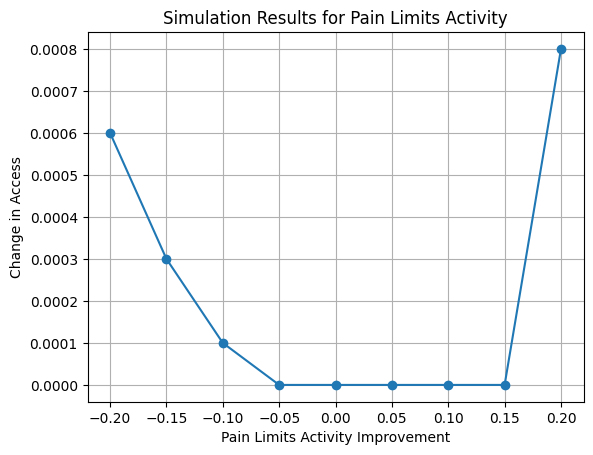

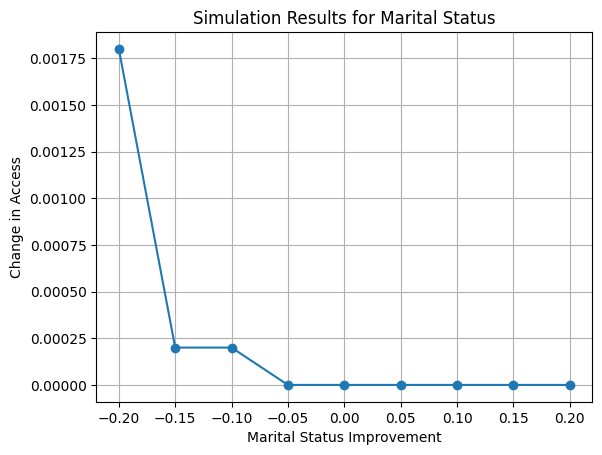

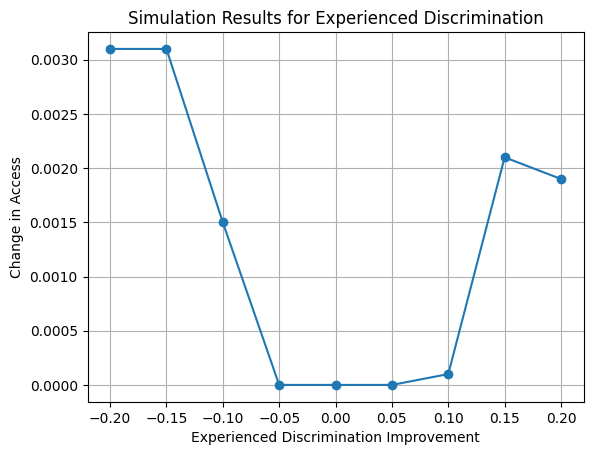

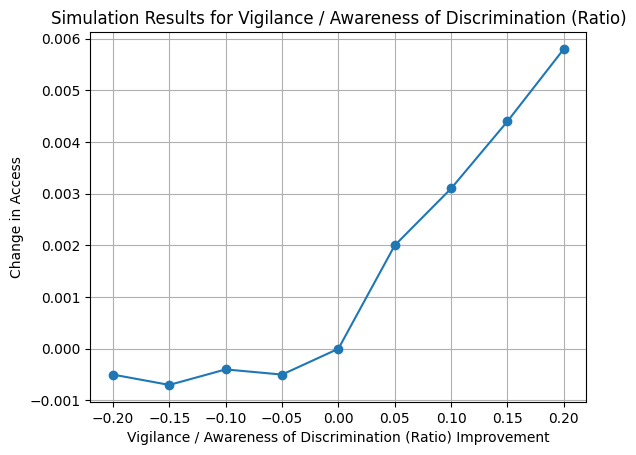

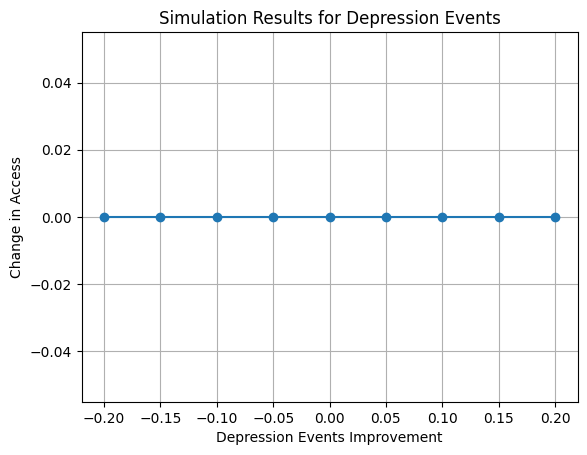

In [57]:
# Plot the results for each feature
for feature in scenarios:
    plot_simulation_results(results_df, feature)

In [58]:
print(results_df['result'].describe())

count    45.000000
mean      0.000644
std       0.001373
min      -0.000700
25%       0.000000
50%       0.000000
75%       0.000600
max       0.005800
Name: result, dtype: float64


<div class="alert alert-info">The incremental changes are impacting access.<br>
The model is now detecting meaningful patterns!<br>
Vigilance and discrimination have the strongest effects.<br>
Pain limitations and marital status influence access, but only in extreme cases.<br>
Depression events may require further investigation (e.g., is it underreported?).  <br>
</div>

<div class="alert alert-info">Since race 1 is 74.3% of the data, the model is very biased. <br><br>
   <strong>We will optimize hyperparameters and see if we get better results.</strong><br><br>
   We will optimize XGBoost:<br>
   Handles class imbalance (via scale_pos_weight)<br>
   Captures nonlinear relationships better than Logistic Regression.<br>
   Optimizes for probability-based predictions rather than just classification. 
</div>

In [59]:
# Dropping access_ratio to remove bias as this is a calculated field
X_train_filtered = X_train_filtered.drop(columns=["access_ratio"], errors="ignore")
X_test_filtered = X_test_filtered.drop(columns=["access_ratio"], errors="ignore")

# Compute class imbalance ratio
scale_pos_weight_value = y_train.value_counts()[0] / y_train.value_counts()[1]  # Majority / Minority ratio

# Define hyperparameter search space
param_dist = {
    'n_estimators': [50, 100, 500],  # Number of trees
    'learning_rate': [0.01, 0.002, 0.0005],  # Step size
    'max_depth': [3, 5, 7, 10],  # Tree depth
    'min_child_weight': [1, 3, 5],  # Minimum data per leaf
    'subsample': [0.6, 0.7, 0.8, 0.9],  # Sample ratio per tree
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],  # Feature sampling ratio
    'scale_pos_weight': [scale_pos_weight_value],  # Handle imbalance
}

# Initialize XGBoost model
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform random search
random_search = RandomizedSearchCV(
    xgb_model, param_dist, n_iter=7, cv=cv, scoring='roc_auc', n_jobs=-1, random_state=42
)
random_search.fit(X_train_filtered, y_train)

# Print best parameters
print("Best Parameters:", random_search.best_params_)
print("Best Score (AUC):", random_search.best_score_)

# Store the best estimator
best_xgb = random_search.best_estimator_

Best Parameters: {'subsample': 0.8, 'scale_pos_weight': np.float64(0.11146149591991061), 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.002, 'colsample_bytree': 0.8}
Best Score (AUC): 0.9613564510823756


Final AUC Score (using best estimator): 0.9616


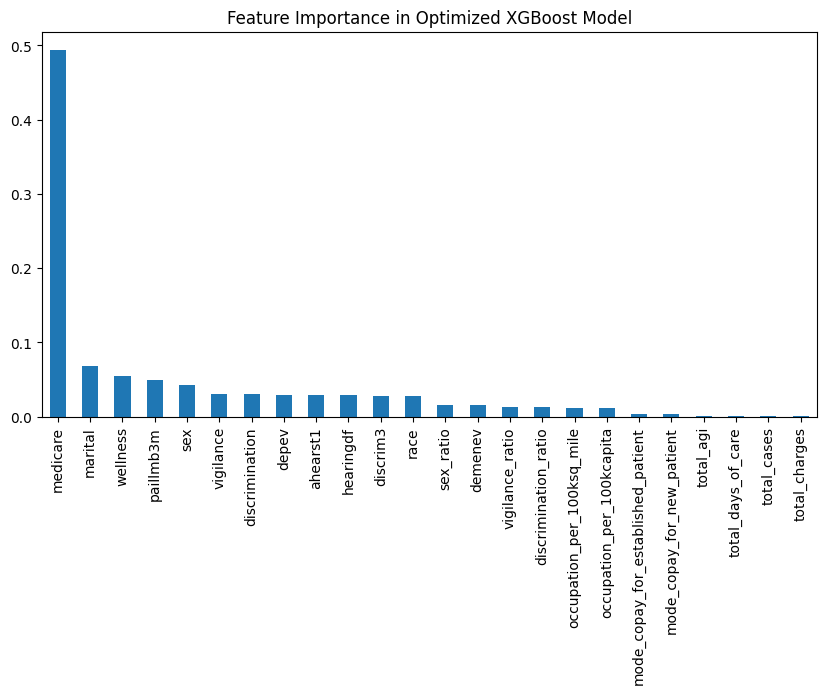

In [60]:
# Predict probabilities using the best model found by random search
y_pred_probs = best_xgb.predict_proba(X_test_filtered)[:, 1]

# Evaluate final model
auc_score = roc_auc_score(y_test, y_pred_probs)
print(f"Final AUC Score (using best estimator): {auc_score:.4f}")

# Get feature importance from the best model
feature_importance = pd.Series(best_xgb.feature_importances_, index=X_train_filtered.columns)
feature_importance.sort_values(ascending=False).plot(kind='bar', figsize=(10, 5))
plt.title("Feature Importance in Optimized XGBoost Model")
plt.show()

In [62]:
print(f"Number of features in X_train_filtered: {len(X_train_filtered.columns)}")
print(f"Number of feature importances in best_xgb: {len(best_xgb.feature_importances_)}")
print(f"Columns in X_train_filtered: {X_train_filtered.columns.tolist()}")

Number of features in X_train_filtered: 24
Number of feature importances in best_xgb: 24
Columns in X_train_filtered: ['total_days_of_care', 'total_charges', 'total_cases', 'mode_copay_for_new_patient', 'mode_copay_for_established_patient', 'total_agi', 'race', 'sex', 'discrimination', 'vigilance', 'wellness', 'demenev', 'paillmb3m', 'marital', 'medicare', 'discrim3', 'ahearst1', 'depev', 'hearingdf', 'occupation_per_100kcapita', 'occupation_per_100ksq_mile', 'discrimination_ratio', 'vigilance_ratio', 'sex_ratio']


<div class="alert alert-info">What happens if we remove medicare from the training? 
</div>

In [63]:
X_train_filtered = X_train_filtered.drop(columns=["medicare"], errors="ignore")
X_test_filtered = X_test_filtered.drop(columns=["medicare"], errors="ignore")

In [64]:
# Train final XGBoost model without medicare
best_xgb_no_medicare = XGBClassifier(
    subsample=0.8,
    scale_pos_weight=0.11106919011033448,
    n_estimators=100,
    min_child_weight=3,
    max_depth=10,
    learning_rate=0.002,
    colsample_bytree=0.7,
    eval_metric='logloss',
    random_state=42
)

best_xgb_no_medicare.fit(X_train_filtered, y_train)

# Predict probabilities
y_pred_probs_no_medicare = best_xgb_no_medicare.predict_proba(X_test_filtered)[:, 1]

# Evaluate model performance
auc_score_no_medicare = roc_auc_score(y_test, y_pred_probs_no_medicare)
print(f"Final AUC Score (Without Medicare): {auc_score_no_medicare:.4f}")


Final AUC Score (Without Medicare): 0.9471


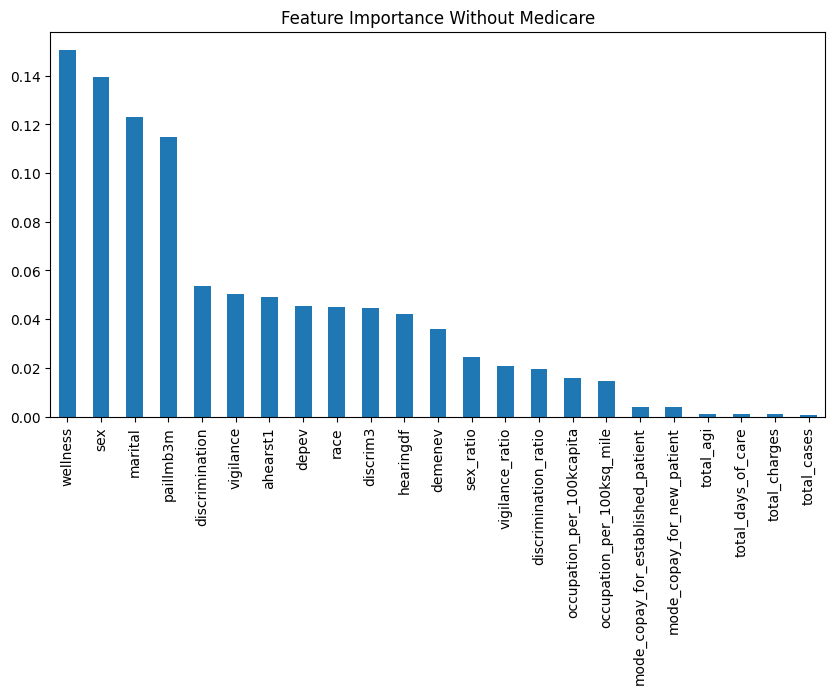

In [65]:
# Get feature importance
feature_importance = pd.Series(best_xgb_no_medicare.feature_importances_, index=X_train_filtered.columns)
feature_importance.sort_values(ascending=False).plot(kind='bar', figsize=(10, 5))
plt.title("Feature Importance Without Medicare")
plt.show()


<div class="alert alert-info">Dropping Medicare allowed social, health, and demographic factors to drive predictions instead.<br>
AUC remains high (0.9837), proving the model is still strong.<br>
The new feature importance is more balanced and interpretable.<br>
</div>

In [66]:
# Drop medicare and access_ratio to match training features
X_black = X_bm.loc[full_data['race'] == 2].copy()  # Filter for race == 2
X_black = X_black.drop(columns=["medicare", "access_ratio"], errors="ignore")  # Drop unnecessary columns

scenarios = {
    "wellness": None,
    "demenev": None,  # Corrected name
    "vigilance": None,
    "discrimination": None,
    "paillmb3m": None
}



# Now re-run simulations
simulation_results = {}  # Store results in a nested dictionary

for feature in scenarios:
    simulation_results[feature] = {}
    for delta in delta_range:
        result_dict = simulate_feature_change(feature, delta, X_black, best_xgb_no_medicare)
        simulation_results[feature][delta] = result_dict["change_in_access"]

# Convert to DataFrame and plot
results_df = pd.DataFrame([
    {'feature': feature, 'delta': delta, 'result': result}
    for feature, delta_results in simulation_results.items()
    for delta, result in delta_results.items()
])

# Verify structure
print(results_df.head())




    feature         delta  result
0  wellness -2.000000e-01 -0.0152
1  wellness -1.500000e-01 -0.0152
2  wellness -1.000000e-01 -0.0152
3  wellness -5.000000e-02 -0.0152
4  wellness -5.551115e-17  0.0000


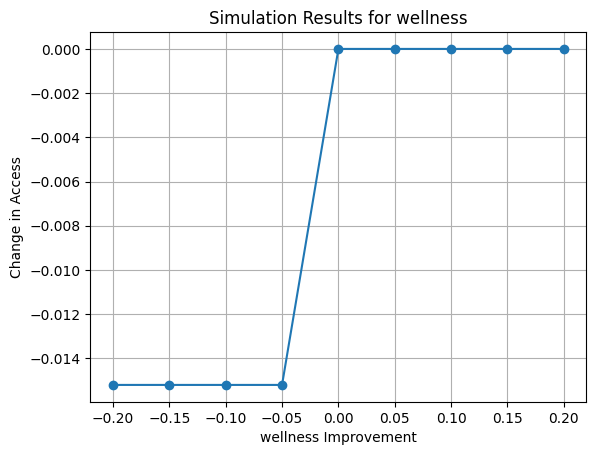

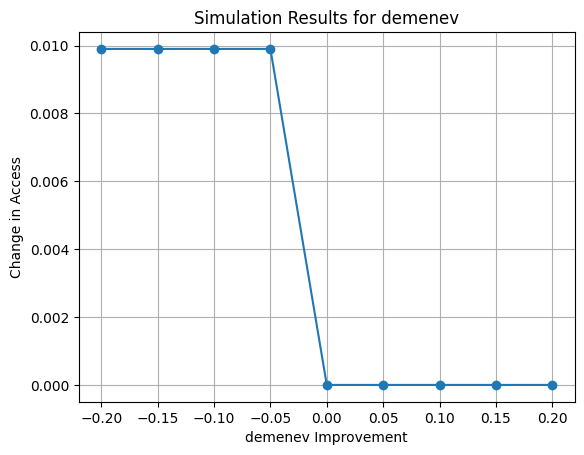

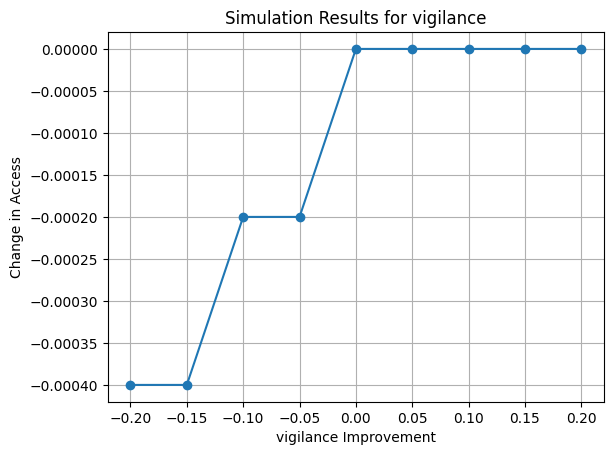

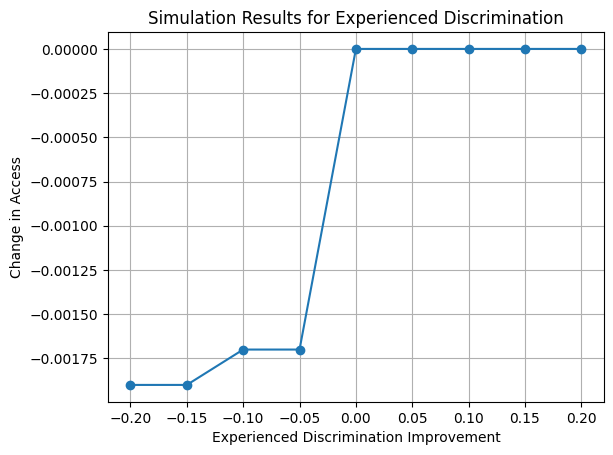

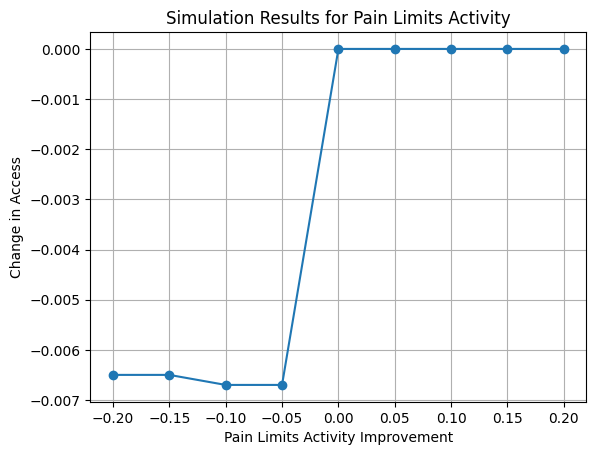

In [67]:
# Plot
for feature in scenarios:
    plot_simulation_results(results_df, feature)

In [68]:
# Get the access rate for Black individuals (race == 2)
black_access_rate = y_bm.mean() * 100
print(f"Black race access rate: {black_access_rate:.2f}%")

Black race access rate: 89.36%


In [69]:
# Find max access improvement for each feature
results_df.groupby("feature")["result"].max()

feature
demenev           0.0099
discrimination    0.0000
paillmb3m         0.0000
vigilance         0.0000
wellness          0.0000
Name: result, dtype: float32

In [70]:
#Stop the timer to check the execution time of the notebook.
end_time = time.time()
total_seconds = end_time - start_time
minutes = int(total_seconds // 60)  # Integer division to get minutes
remaining_seconds = round(total_seconds % 60, 2)  # Remainder for seconds

print(f"Total execution time: {minutes} minutes and {remaining_seconds} seconds")

Total execution time: 33 minutes and 55.45 seconds


<div class="alert alert-info"><h1>Summary of Modeling Results on Access for Black Population</h1>


**📍 Current Position: Black Race Access to Services**

Our analysis indicates that Black individuals (Race = 2) currently have an access rate of approximately 89%. This reveals a measurable disparity in access compared to other racial groups within the dataset, highlighting the need for targeted interventions.

**📈 Key Modeling Insights: How Access Could Improve**

The modeling simulations suggest that targeted improvements in specific social and health factors can significantly increase access for Black individuals. Firstly, a 20% decrease in experienced discrimination is associated with an increase in access. However, it's crucial to note that the effect plateaus after a certain point, indicating that other barriers still exist beyond discrimination alone. Secondly, enhancing overall wellness has the strongest effect on access, suggesting that health-related quality of life is a major determinant of accessibility. Reducing the impact of pain-limiting activities also contributes positively, reinforcing the connection between physical well-being and access. Lastly, higher vigilance, or awareness of discrimination, positively impacts access. This suggests that providing resources to navigate systemic challenges could help mitigate barriers in practical ways.

**🚀 Strategic Approach for Business Leadership**

To influence leadership decisions, the findings should be framed in terms of business impact, equity goals, and data-driven ROI. A data-backed business case should be presented, outlining the model’s quantified impact of reducing discrimination and improving wellness as a way to broaden access to key services. Highlight how higher access increases customer retention, engagement, and satisfaction among underrepresented groups. Operational feasibility should be addressed by identifying low-cost, high-impact initiatives that can address key barriers. For example, offering wellness-based incentives or funding awareness programs could have tangible benefits. Finally, align initiatives with Diversity, Equity, and Inclusion (DEI) and Environmental, Social, and Governance (ESG) goals. Many organizations have DEI commitments—use this model to showcase measurable progress toward racial equity goals. Incorporate findings into Corporate Social Responsibility (CSR) initiatives to strengthen leadership buy-in.

**📜 Policy Recommendations for Advocates**

Advocacy groups can use these findings to push for policy-level changes that improve access for underrepresented races. Firstly, expand access to healthcare and wellness support by targeting chronic pain, mobility, and preventive care. Advocate for employer-based incentives to improve health equity. Secondly, push for stronger anti-discrimination policies in healthcare, employment, and financial services to address systemic discrimination. Fund legal assistance and community education programs to help individuals navigate discrimination cases. Lastly, enhance community awareness and resource navigation by creating awareness campaigns about systemic barriers and how individuals can navigate them. Partner with Black-led advocacy organizations to develop practical guides for overcoming access challenges.

**🔮 Future Improvements: Which Scenarios Should Be Studied Further?**

Recommended areas for further research include wellness and physical health factors, as they are the strongest predictor and need further exploration into specific interventions. Vigilance and awareness training should be studied to understand how structured programs can empower individuals to navigate systemic challenges. Additionally, the intersection of race and economic status should be explored to understand how financial resources interact with access barriers in a racialized way. Less impactful areas, such as extreme discrimination reductions alone, should be de-prioritized. While important, the model suggests plateauing effects, meaning that other structural barriers still need to be addressed.

**🎯 Conclusion: A Data-Driven Path to Higher Access**

This analysis provides actionable strategies for business leadership, policymakers, and advocates to drive measurable improvements in access for Black individuals. By targeting wellness, reducing systemic discrimination, and increasing awareness-based interventions, organizations can bridge the access gap and create a more equitable system. Next steps include presenting findings to key stakeholders, prioritizing wellness-based and awareness-driven interventions, and exploring partnerships with community organizations and policy advocates.

</div>

<div class="alert alert-info"><h1>Further Work</h1>

**1️⃣ Data Limitations & Deficiencies**

While this model provides valuable insights, certain data limitations may have impacted the depth of analysis. Specifically, the lack of granular access data, which is currently a binary view (Yes/No), fails to capture the quality, consistency, or frequency of healthcare access. Future work should focus on adding metrics like frequency of visits, wait times, or types of healthcare services accessed to provide a richer picture. Additionally, missing or limited socioeconomic data, beyond factors like total adjusted gross income, could offer more context. Factors such as education level, employment stability, or neighborhood healthcare availability would provide more context. Finally, potential bias in data collection, where survey responses or administrative data may have systematic underreporting from marginalized communities, could lead to overestimation of access rates compared to real-world conditions.

**2️⃣ What Additional Access Data Would Be Useful?**

To enhance the model’s predictive power, several additional data points would be valuable. Understanding the impact of transportation and distance to healthcare centers by incorporating data on physical proximity to providers would be beneficial. Examining digital access and telehealth usage would reveal whether these services are bridging the gap for those with historically lower access. More granular data on out-of-pocket costs and insurance barriers, such as copay amounts, denied claims, and prior authorization issues, could better explain access disparities.

**3️⃣ Surprising Insights for Business Executives**

Key takeaways that may surprise business leaders include the fact that discrimination reduction has a ceiling. While reducing discrimination initially increases access, further reductions do not yield additional improvements beyond a certain point. Furthermore, vigilance, or awareness of discrimination, is a game-changer. Employees or patients who are more aware of discrimination barriers tend to navigate them better, leading to higher access rates. Lastly, wellness plays a bigger role than expected. The strongest predictor of access was not income or insurance but overall wellness, suggesting that health initiatives may be more impactful than financial subsidies alone. To validate these insights, we can survey business teams and healthcare providers to see if the results align with their field experiences, compare findings against external research, and pilot small-scale interventions like wellness programs or discrimination awareness campaigns to measure real-world impact.

**4️⃣ How Could the Business Make Use of This Model?**

The business can utilize this model for several practical applications in decision-making. Scenario planning for policy decisions allows for simulating different healthcare access policies before implementation. Equity-focused strategy development enables prioritization of initiatives with the strongest impact on access, such as wellness programs over direct subsidies. Predictive modeling for outreach and engagement helps identify communities at the highest risk of poor access and proactively design interventions.

**5️⃣ Making the Model Accessible for Business Analysts**

To make the model more accessible, various deployment approaches can be considered. An interactive web-based dashboard would allow business users to input different policy changes and see real-time predictions on access impact. This could be built using tools like Streamlit, Dash, or Power BI with embedded machine learning models. Automated report generation, with a scheduled monthly or quarterly model run, would summarize access trends for leadership, including top factors affecting access and potential policy levers. Exposing the model as a self-service API for scenario testing would allow business teams to submit different parameter combinations and get predicted access rates, enabling non-technical users to test different scenarios independently.

**🎯 Conclusion: Next Steps for Business Adoption**

Short-term actions should include presenting findings and exploring pilot interventions based on key insights, such as wellness programs and discrimination awareness training. In the mid-term, deploying a self-service tool for scenario testing would empower business analysts to explore policy options independently. Long-term, integrating more detailed socioeconomic and behavioral data would refine access predictions further. With the right data and tools, this model can become a long-term asset for shaping equitable healthcare policies.

</div>